In [ ]:
!pip3 install cvnn

In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 686kB 10.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import glob
import os

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
from tensorflow.keras import models
import cvnn.layers as complex_layers
from cvnn.activations import cart_relu

In [ ]:
image_size  = 180

# Dataset

In [ ]:
import urllib.request

#url = 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'
url = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_full.tgz'
urllib.request.urlretrieve(url, '/content/BSDS300-images.tgz')

('/content/BSDS300-images.tgz', <http.client.HTTPMessage at 0x7fbb02232e90>)

In [ ]:
!tar -xvzf /content/BSDS300-images.tgz

In [ ]:
!rm /content/BSDS300-images.tgz

In [ ]:
!mkdir /content/drive/MyDrive/CDNet

mkdir: cannot create directory ‘/content/drive/MyDrive/CDNet’: File exists


In [ ]:
!mkdir /content/drive/MyDrive/CDNet/data

mkdir: cannot create directory ‘/content/drive/MyDrive/CDNet/data’: File exists


In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(img, img_name, label):
  feature = {
      'image': _bytes_feature(img),
      'image_name': _bytes_feature(img_name),
      'target': _bytes_feature(label),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

def sp_noise(img, snr = 0.9):
  h=img.shape[0]
  w=img.shape[1]
  img1=img.copy()
  sp=h*w # Calculate the number of image pixels
  NP=int(sp*(1-snr)) # Calculate the number of image salt and pepper noise points
  for i in range (NP):
    randx = np.random.randint(1,h-1) # Generate a random integer between 1 and h-1
    randy = np.random.randint(1,w-1) # Generate a random integer between 1 and w-1
    # np.random.random() generates a floating point number between 0 and 1.
    if np.random.random()<=0.5:
          img1[randx,randy]=0.0
    else:
        img1[randx,randy]=1.0
  return img1


########################################################
############ Train TFRecord ############################
########################################################
max_std= 0.3
save_path = '/content/drive/MyDrive/CDNet/data'
path_images = '/content/BSR/BSDS500/data/images/train'
images_list = glob.glob(os.path.join(path_images, '*.jpg'))
path_images = '/content/BSR/BSDS500/data/images/val'
images_list = images_list + glob.glob(os.path.join(path_images, '*.jpg'))
with tf.io.TFRecordWriter(os.path.join(save_path, 'train.tfrec')) as writer:
  for img_name in images_list:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
    img = cv2.resize(img, (image_size,image_size))
    img_to_save = img.copy()
    img = np.float32(img)/255.0

    # add guassian noise
    row,col,ch= img.shape
    mean = 0
    sigma = np.random.random()*max_std
    gauss = np.random.normal(mean, sigma, img.shape)
    gauss = gauss.reshape(row,col,ch)
    noisy = np.add(img, gauss)
    noisy[np.where(noisy>1.0)] = 1.0
    noisy = np.uint8(noisy*255.0)
    noisy = cv2.imencode('.jpg', noisy, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
    img_enc = cv2.imencode('.jpg', img_to_save, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
    example = serialize_example(noisy, str.encode('AWGN_' + img_name), img_enc)
    writer.write(example)

    # add salt and pepper noise
    noisy = sp_noise(img, snr = 0.9 + 0.05*np.random.random())
    noisy = np.uint8(noisy*255.0)
    noisy = cv2.imencode('.jpg', noisy, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
    example = serialize_example(noisy, str.encode('s&p' + img_name), img_enc)
    writer.write(example)


########################################################
############ Test TFRecord ############################
########################################################
save_path = '/content/drive/MyDrive/CDNet/data'
path_images = '/content/BSR/BSDS500/data/images/test'
images_list = glob.glob(os.path.join(path_images, '*.jpg'))
with tf.io.TFRecordWriter(os.path.join(save_path, 'test.tfrec')) as writer:
  for img_name in images_list:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
    img = cv2.resize(img, (image_size,image_size))
    img_to_save = img.copy()
    img = np.float32(img)/255.0

    # add guassian noise
    row,col,ch= img.shape
    mean = 0
    sigma = np.random.random()*max_std
    gauss = np.random.normal(mean, sigma, img.shape)
    gauss = gauss.reshape(row,col,ch)
    gauss = gauss.astype(np.float32)
    noisy = np.add(img, gauss)
    noisy[np.where(noisy>1)] = 1.0
    noisy = np.uint8(noisy*255.0)
    noisy = cv2.imencode('.jpg', noisy, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
    img_enc = cv2.imencode('.jpg', img_to_save, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
    example = serialize_example(noisy, str.encode('AWGN_' + img_name), img_enc)
    writer.write(example)

    # add salt and pepper noise
    noisy = sp_noise(img, snr = 0.9 + 0.05*np.random.random())
    noisy = np.uint8(noisy*255.0)
    noisy = cv2.imencode('.jpg', noisy, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
    example = serialize_example(noisy, str.encode('s&p_' + img_name), img_enc)
    writer.write(example)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


# Generator

In [ ]:
def cutout(image, label, pad_size, replace=0):
  """Apply cutout (https://arxiv.org/abs/1708.04552) to image.

  This operation applies a (2*pad_size x 2*pad_size) mask of zeros to
  a random location within `img`. The pixel values filled in will be of the
  value `replace`. The located where the mask will be applied is randomly
  chosen uniformly over the whole image.

  Args:
    image: An image Tensor of type uint8.
    pad_size: Specifies how big the zero mask that will be generated is that
      is applied to the image. The mask will be of size
      (2*pad_size x 2*pad_size).
    replace: What pixel value to fill in the image in the area that has
      the cutout mask applied to it.

  Returns:
    An image Tensor that is of type uint8.
  """
  image_height = tf.shape(image)[0]
  image_width = tf.shape(image)[1]

  # Sample the center location in the image where the zero mask will be applied.
  cutout_center_height = tf.random.uniform(
      shape=[], minval=0, maxval=image_height,
      dtype=tf.int32)

  cutout_center_width = tf.random.uniform(
      shape=[], minval=0, maxval=image_width,
      dtype=tf.int32)

  lower_pad = tf.maximum(0, cutout_center_height - pad_size)
  upper_pad = tf.maximum(0, image_height - cutout_center_height - pad_size)
  left_pad = tf.maximum(0, cutout_center_width - pad_size)
  right_pad = tf.maximum(0, image_width - cutout_center_width - pad_size)

  cutout_shape = [image_height - (lower_pad + upper_pad),
                  image_width - (left_pad + right_pad)]
  padding_dims = [[lower_pad, upper_pad], [left_pad, right_pad]]
  mask = tf.pad(
      tf.zeros(cutout_shape, dtype=image.dtype),
      padding_dims, constant_values=1)
  mask = tf.expand_dims(mask, -1)
  mask = tf.tile(mask, [1, 1, 3])
  image = tf.where(
      tf.equal(mask, 0),
      tf.ones_like(image, dtype=image.dtype) * replace,
      image)
  label = tf.where(
      tf.equal(mask, 0),
      tf.ones_like(label, dtype=label.dtype) * replace,
      label)
  return image, label


In [ ]:
# Create a dictionary describing the features.
image_feature_description = {

    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'target': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def preprocess(features,effesionet=True):
  image_raw = features['image']
  image = tf.io.decode_image(image_raw,channels=3)
  image.set_shape([image_size,image_size,3])
  label_raw = features['target']
  label = tf.io.decode_image(label_raw,channels=3)
  image.set_shape([image_size,image_size,3])
  return image, label


def normalize(image ,label):
  image =  tf.cast(image,tf.uint8)
  image = tf.cast(image,tf.float32)/255.0
  #scale = tf.constant([0.229, 0.224, 0.225])
  #offset = tf.constant([0.485, 0.456, 0.406])
  #image -= offset
  #image /= scale

  label =  tf.cast(label,tf.uint8)
  label = tf.cast(label,tf.float32)/255.0
  return image , label


@tf.function
def agment(image,label):
  image = tf.cast(image, dtype= tf.float32)
  label = tf.cast(label, dtype= tf.float32)

  if tf.random.uniform((),0,1.)<0.5:
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)

  #print(image)
  if tf.random.uniform((),0,1.)<0.5:
    for i in range(3 + np.random.randint(10, size=1)[0]):
      image, label = cutout(image, label, 12, replace=0)
      #label = cutout(label, 20, replace=0)

  if tf.random.uniform((),0,1.)<0.5:
    #print(image)
    rnd = np.random.uniform(0,1,1)[0]*360
    image = tfa.image.rotate(image, rnd)
    label = tfa.image.rotate(label, rnd)
    #print('rotate shape', image.shape)
    #print(image)
  if tf.random.uniform((),0,1.)<0.5:
    #print(image)
    shearx = np.random.uniform(0,0.3,1)[0]
    sheary = np.random.uniform(0,0.3,1)[0]
    image = tfa.image.shear_y( image, shearx , 0.)
    image = tfa.image.shear_x( image, sheary, 0.)
    label = tfa.image.shear_y( label, shearx , 0.)
    label = tfa.image.shear_x( label, sheary, 0.)

  # random crop
  if tf.random.uniform((),0,1.)<0.5:
    h = np.random.randint(image_size//3, size=1)[0]+10
    h = h//2 # 10%
    w = np.random.randint(image_size//3, size=1)[0]+10
    w = w//2 # 10%
    cropped_image = image[h:image_size - h, w:image_size - w,:]
    image = tf.pad(cropped_image, [[h,h], [w,w], [0,0]])
    image = tf.image.resize(image,(image_size,image_size))

    cropped_label = label[h:image_size - h, w:image_size - w,:]
    label = tf.pad(cropped_label, [[h,h], [w,w], [0,0]])
    label = tf.image.resize(label,(image_size,image_size))

  '''
  if tf.random.uniform((),0,1.)<0.5:
    image = equalize(image)
    image = tf.cast(image, dtype= tf.float32)
  if tf.random.uniform((),0,1.)<0.5:
    h = np.random.randint(image_size//3, size=1)[0]+10
    h = h//2 # 10%
    w = np.random.randint(image_size//3, size=1)[0]+10
    w = w//2 # 10%
    cropped_image = image[h:image_size - h, w:image_size - w,:]
    image = tf.pad(cropped_image, [[h,h], [w,w], [0,0]])
    image = tf.image.resize(image,(image_size,image_size))
  if tf.random.uniform((),0,1.)<0.5:
    image = tf.image.random_brightness(image, np.random.uniform(0,1,1)[0])
  if tf.random.uniform((),0,1.) >= 0.4:
        image = tf.image.random_saturation(image, lower = 0.7, upper = 1.3)
  if tf.random.uniform((),0,1.) >= 0.4:
      image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)

  if tf.random.uniform((),0,1.)<0.5:
    image = solarize(image)
  '''
  #print(image)
  return image , label


In [ ]:
BATCH_SIZE = 8
ds_train = tf.data.TFRecordDataset(['/content/drive/MyDrive/CDNet/data/train.tfrec'])
ds_train = ds_train.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(50).prefetch(100)
ds_train  =  ds_train.map(preprocess).map(agment)#
ds_train  = ds_train.map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
BATCH_SIZE = 8
ds_val = tf.data.TFRecordDataset(['/content/drive/MyDrive/CDNet/data/test.tfrec'])
ds_val = ds_val.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val  =  ds_val.map(preprocess)
ds_val  = ds_val.map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
img, label = next(iter(ds_train))
img.shape

TensorShape([8, 180, 180, 3])

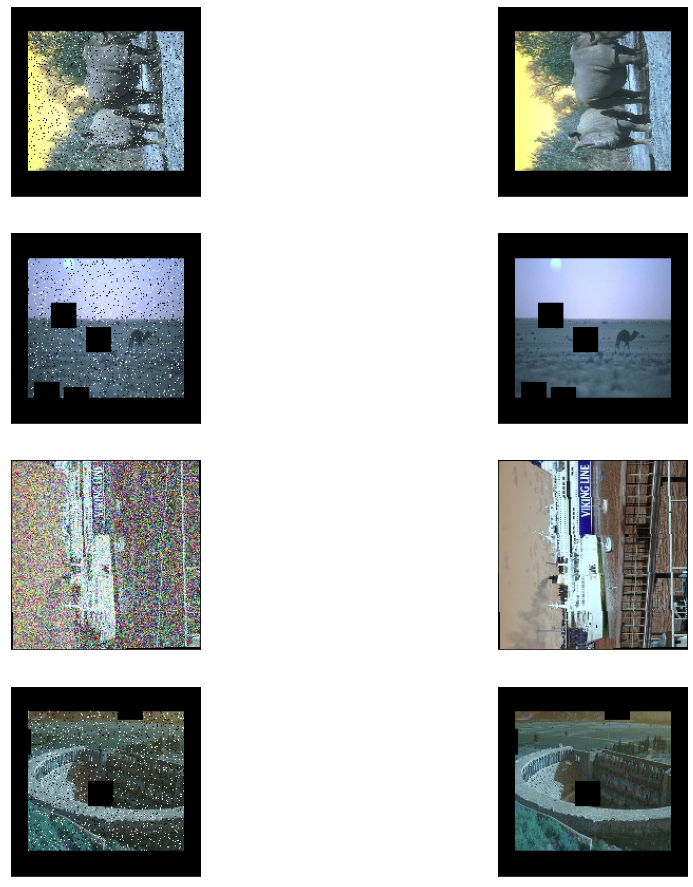

In [ ]:
fig = plt.figure(figsize=(16,16))
for j in range(4):
  plt.subplot(4,2, j*2 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = img[j].numpy()
  plt.imshow(image)

  plt.subplot(4,2, j*2 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = label[j].numpy()
  plt.imshow(image)


# Layers and the Model

In [ ]:
class ComplexBatchNormalization(tf.keras.layers.Layer):
  """
  tf.keras.layers.BatchNormalization(
      axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
      beta_initializer='zeros', gamma_initializer='ones',
      moving_mean_initializer='zeros',
      moving_variance_initializer='ones', beta_regularizer=None,
      gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, **kwargs
  )

  """
  def __init__ (self,
                axis=-1,
                momentum=0.99,
                epsilon=0.001,
                center=True,
                scale=True,
                beta_initializer='zeros',
                gamma_initializer='ones',
                moving_mean_initializer='zeros',
                moving_variance_initializer='ones',
                beta_regularizer=None,
                gamma_regularizer=None,
                beta_constraint=None,
                gamma_constraint=None):
    super(ComplexBatchNormalization, self).__init__()
    self.axis = axis
    self.momentum = momentum
    self.epsilon = epsilon
    self.center = center
    self.scale = scale
    self.beta_initializer = beta_initializer
    self.gamma_initializer = gamma_initializer
    self.moving_mean_initializer = moving_mean_initializer
    self.moving_variance_initializer = moving_variance_initializer
    self.beta_regularizer = beta_regularizer
    self.gamma_regularizer = gamma_regularizer
    self.beta_constraint = beta_constraint
    self.gamma_constraint = gamma_constraint
    self.real_bn = tf.keras.layers.BatchNormalization(
        axis = self.axis,
        momentum = self.momentum,
        epsilon = self.epsilon,
        center = self.center,
        scale =self. scale,
        beta_initializer = self.beta_initializer,
        gamma_initializer = self.gamma_initializer,
        moving_mean_initializer = self.moving_mean_initializer,
        moving_variance_initializer = self.moving_variance_initializer,
        beta_regularizer = self.beta_regularizer,
        gamma_regularizer = self.gamma_regularizer,
        beta_constraint = self.beta_constraint,
        gamma_constraint = self.gamma_constraint)

    self.imag_bn = tf.keras.layers.BatchNormalization(
        axis = self.axis,
        momentum = self.momentum,
        epsilon = self.epsilon,
        center = self.center,
        scale =self. scale,
        beta_initializer = self.beta_initializer,
        gamma_initializer = self.gamma_initializer,
        moving_mean_initializer = self.moving_mean_initializer,
        moving_variance_initializer = self.moving_variance_initializer,
        beta_regularizer = self.beta_regularizer,
        gamma_regularizer = self.gamma_regularizer,
        beta_constraint = self.beta_constraint,
        gamma_constraint = self.gamma_constraint)

  def call (self, inputs, training = True):

    real_inputs = tf.math.real(inputs)
    imag_inputs = tf.math.imag(inputs)

    real_outputs = self.real_bn(real_inputs, training = training)
    imag_outputs = self.imag_bn(imag_inputs, training = training)

    return tf.cast(tf.complex(real_outputs, imag_outputs), dtype=inputs.dtype)

In [ ]:
class ComplexRB (tf.keras.layers.Layer):
  def __init__(self,
              filters = 64,
              kernel_size = 3,
              strides = 2,
              padding = "same"):
    super(ComplexRB, self).__init__()
    self.filters            = filters
    self.kernel_size        = kernel_size
    self.strides            = strides
    self.padding            = padding
    self.cmplx_conv1 = complex_layers.ComplexConv2D (self.filters,
                                                    (self.kernel_size, self.kernel_size),
                                                    activation = None,
                                                    padding = self.padding,
                                                    dtype = tf.complex64)
    self.cmplx_bn1 = ComplexBatchNormalization()

    self.cmplx_conv2 = complex_layers.ComplexConv2D (self.filters,
                                                    (self.kernel_size, self.kernel_size),
                                                    activation = None,
                                                    padding = self.padding,
                                                    dtype = tf.complex64)
    self.cmplx_bn2 = ComplexBatchNormalization()
  def call(self, z, training = True):
    x = self.cmplx_conv1(z)
    x = self.cmplx_bn1(x, training = training)
    x = cart_relu(x)

    x = self.cmplx_conv2(x)
    x = self.cmplx_bn2(x, training = training)

    x = tf.keras.layers.Add()([x, z])

    x = cart_relu(x)
    return x

In [ ]:
from tensorflow import keras

class CDNet (keras.Model):
  def __init__(self,
              filters = 64,
              kernel_size = 3,
              strides = 2):
    super(CDNet, self).__init__()
    self.filters            = filters
    self.kernel_size        = kernel_size
    self.strides            = strides

    self.cmplx_conv1 = complex_layers.ComplexConv2D(self.filters,
                                                    (self.kernel_size, self.kernel_size),
                                                    activation = 'cart_relu',
                                                    padding = 'same',
                                                    dtype = tf.complex64)
    self.cmplx_conv2 = complex_layers.ComplexConv2D(self.filters,
                                                    (self.kernel_size, self.kernel_size),
                                                    activation = None,
                                                    padding = 'same',
                                                    dtype = tf.complex64)
    self.cmplx_bn2 = ComplexBatchNormalization()

    self.cmplx_conv3 = complex_layers.ComplexConv2D(self.filters,
                                                    (self.kernel_size, self.kernel_size),
                                                    strides=(self.strides, self.strides),
                                                    activation = None,
                                                    padding = 'valid',
                                                    dtype = tf.complex64)
    self.cmplx_bn3 = ComplexBatchNormalization()
    self.cmplxRB = models.Sequential()
    for i in range(9):
      self.cmplxRB.add(ComplexRB(filters = self.filters,
                                 kernel_size = self.kernel_size,
                                 padding = "same")
      )


    self.cmplx_conv_t = complex_layers.ComplexConv2DTranspose(self.filters,
                                                              (self.kernel_size, self.kernel_size),
                                                              strides=(self.strides, self.strides),
                                                              output_padding = (1,1),
                                                              activation = None,
                                                              padding = 'valid',
                                                              dtype = tf.complex64)
    self.cmplx_bn4 = ComplexBatchNormalization()

    self.cmplx_conv5 = complex_layers.ComplexConv2D(self.filters,
                                                    (self.kernel_size, self.kernel_size),
                                                    activation = None,
                                                    padding = 'same',
                                                    dtype = tf.complex64)
    self.cmplx_bn5 = ComplexBatchNormalization()

    self.cmplx_conv6 = complex_layers.ComplexConv2D(3,
                                                    (self.kernel_size, self.kernel_size),
                                                    activation = None,
                                                    padding = 'same',
                                                    dtype = tf.complex64)


  def call(self, inputs, training = True):
    x = tf.cast(tf.complex(inputs, tf.zeros_like(inputs)), tf.complex64)
    x = self.cmplx_conv1(x) # output_size = image_size

    x = self.cmplx_conv2(x) # output_size = image_size
    x = self.cmplx_bn2(x, training = training) # output_size = image_size
    x = cart_relu(x) # output_size = image_size

    x = self.cmplx_conv3(x) # output_size = image_size/2
    x = self.cmplx_bn3(x, training = training) # output_size = image_size/2
    x1 = cart_relu(x) # output_size = image_size/2

    x = self.cmplxRB(x1, training = training)

    x = tf.keras.layers.Add()([x1, x]) # output_size = image_size/2
    x = self.cmplx_conv_t(x) # output_size = image_size
    x = self.cmplx_bn4(x, training = training) # output_size = image_size
    x = cart_relu(x) # output_size = image_size

    x = self.cmplx_conv5(x) # output_size = image_size
    x = self.cmplx_bn5(x, training = training) # output_size = image_size
    x = cart_relu(x) # output_size = image_size

    x = self.cmplx_conv6(x) # output_size = image_size
    output = tf.abs(x) # sqrt(R^2 + Imag^2) = amplitude
    output = tf.keras.layers.ReLU(max_value=1.0)(output)
    return tf.cast(output, dtype=inputs.dtype)

In [ ]:
model = CDNet()
temp_out = model(img, training = False)
temp_out.shape

TensorShape([8, 180, 180, 3])

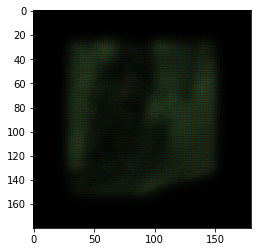

In [ ]:
image = temp_out[0].numpy()
plt.imshow(image)

# Training

In [ ]:
!mkdir /content/drive/MyDrive/CDNet/saved_model1

In [ ]:
TRAIN_STEPS = 604//BATCH_SIZE + 1
VAL_STEPS = 402//BATCH_SIZE

In [ ]:
def PSNR(y_true,y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
#lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-5, TRAIN_STEPS ,decay_rate=0.97)
#optimizer = tf.keras.optimizers.Adam(lr_sc,beta_1=0.9,beta_2=0.999)
model.compile(loss='mse',
              optimizer = optimizer,
              metrics=[tf.keras.metrics.RootMeanSquaredError(), PSNR])

In [ ]:
EPOCHS = 70

In [ ]:
if True:
  model.load_weights('/content/drive/MyDrive/CDNet/saved_model1/saved_model4')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/CDNet/saved_model1/saved_model4"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             save_weights_only=True,
                             verbose=1, save_best_only=True,
                             mode='min')
#callbacks_list = [ checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,) ]
callbacks_list = [ checkpoint]

history = model.fit(ds_train,
                    epochs= EPOCHS,
                    validation_data = ds_val,
                    steps_per_epoch= TRAIN_STEPS,
                    validation_steps = VAL_STEPS,
                    callbacks = callbacks_list)

Epoch 1/70
76/76 [==============================] - 83s 1s/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - PSNR: 23.8532 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816 - val_PSNR: 22.4061

Epoch 00001: val_loss improved from inf to 0.00666, saving model to /content/drive/MyDrive/CDNet/saved_model1/saved_model4
Epoch 2/70
76/76 [==============================] - 82s 1s/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - PSNR: 24.1730 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - val_PSNR: 22.5137

Epoch 00002: val_loss improved from 0.00666 to 0.00653, saving model to /content/drive/MyDrive/CDNet/saved_model1/saved_model4
Epoch 3/70
76/76 [==============================] - 82s 1s/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - PSNR: 23.9563 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796 - val_PSNR: 22.6535

Epoch 00003: val_loss improved from 0.00653 to 0.00633, saving model to /content/drive/MyDrive/CDNet/saved_model1/saved_model4
Ep

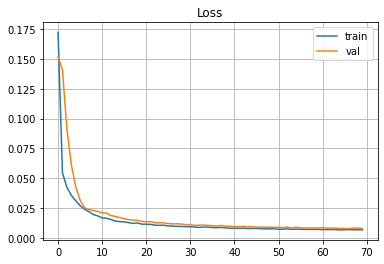

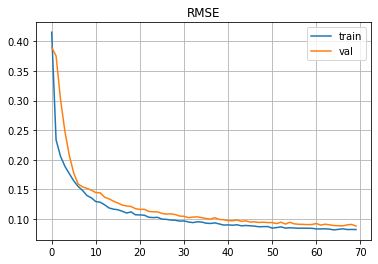

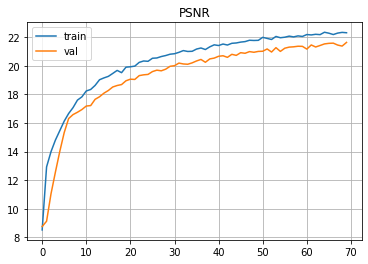

In [ ]:
# plot loss
plt.plot( history.history['loss'],'',  history.history['val_loss'],'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.show()
# plot accuracy
plt.plot(history.history['root_mean_squared_error'],'', history.history['val_root_mean_squared_error'],'-')
plt.title('RMSE')
plt.legend(['train','val'])
plt.grid()
plt.show()

# plot accuracy
plt.plot(history.history['PSNR'],'', history.history['val_PSNR'],'-')
plt.title('PSNR')
plt.legend(['train','val'])
plt.grid()
plt.show()

# Prediction and usage

In [ ]:
model.load_weights('/content/drive/MyDrive/CDNet/saved_model1/saved_model4')

In [ ]:
BATCH_SIZE = 400
ds_val = tf.data.TFRecordDataset(['/content/drive/MyDrive/CDNet/data/test.tfrec'])
ds_val = ds_val.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).prefetch(100)
ds_val  =  ds_val.map(preprocess).map(agment)#
ds_val  = ds_val.map(normalize).batch(BATCH_SIZE,drop_remainder=True)
img, label = next(iter(ds_val))
preds = model.predict(img)
psnr = PSNR(label,preds)
print('PSNR :', np.mean(psnr.numpy()))

PSNR : 24.1819


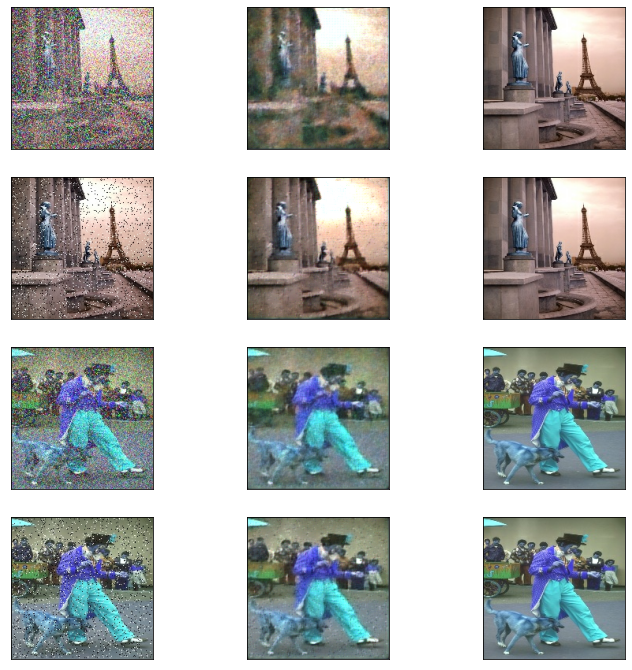

In [ ]:
img, label = next(iter(ds_val))
a = model.predict(img)

fig = plt.figure(figsize=(12,12))
for j in range(4):
  plt.subplot(4,3, j*3 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = img[j].numpy()
  plt.imshow(image)

  plt.subplot(4,3, j*3 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = a[j]
  plt.imshow(image)

  plt.subplot(4,3, j*3 + 3)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = label[j].numpy()
  plt.imshow(image)


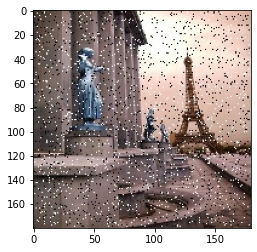

In [ ]:
image = img[1].numpy()
plt.imshow(image)

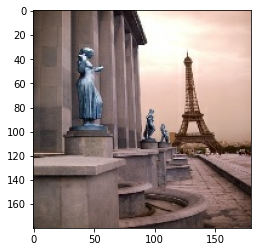

In [ ]:
image = label[1].numpy()
plt.imshow(image)

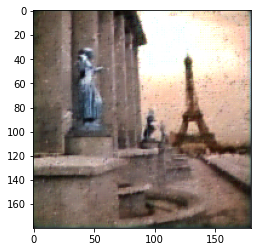

In [ ]:
image = a[1]
plt.imshow(image)

# GWO

In [ ]:
def objFunc(pos, optimizer_input, y):
  n = optimizer_input.shape[0]
  w = pos.reshape(image_size*image_size*3,)
  preds = optimizer_input*w

  mse = tf.keras.metrics.MeanSquaredError()
  mse.update_state(y, preds)
  rmse = tf.keras.metrics.RootMeanSquaredError()
  rmse.update_state(y, preds)
  return mse.result().numpy(), rmse.result().numpy(), tf.image.psnr(y.reshape(n,image_size,image_size,3),
                                                                    preds.reshape(n,image_size,image_size,3), max_val=1.0)


In [ ]:
class solution:
    def __init__(self):
        self.best = 0
        self.Alpha_pos = []
        self.Alpha_score = []

        self.Beta_pos = []
        self.Beta_score = []

        self.Delta_pos = []
        self.Delta_score = []

        self.Positions = []

        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

In [ ]:
import random
import math
import time


def GWO(objf, optimizer_input, y, lb, ub, dim, SearchAgents_no, Max_iter, input_solution = None):

    # Max_iter=1000
    # lb=-100
    # ub=100
    # dim=30
    # SearchAgents_no=5
    if input_solution is not None:
      # initialize alpha, beta, and delta_pos
      Alpha_pos = input_solution.Alpha_pos
      Alpha_score = input_solution.Alpha_score

      Beta_pos = input_solution.Beta_pos
      Beta_score = input_solution.Beta_score

      Delta_pos = input_solution.Delta_pos
      Delta_score = input_solution.Delta_score
      # Initialize the positions of search agents
      Positions = input_solution.Positions
    else:
      # initialize alpha, beta, and delta_pos
      Alpha_pos = np.zeros(dim)
      Alpha_score = float("inf")

      Beta_pos = np.zeros(dim)
      Beta_score = float("inf")

      Delta_pos = np.zeros(dim)
      Delta_score = float("inf")
      # Initialize the positions of search agents
      Positions = np.zeros((SearchAgents_no, dim))

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim

    for i in range(dim):
        Positions[:, i] = (
            np.random.uniform(0, 1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]
        )

    Convergence_curve = np.zeros(Max_iter)
    s = solution()
    # Loop counter
    print('GWO is optimizing  "' + objf.__name__ + '"')

    # Main loop
    for l in range(0, Max_iter):
        for i in range(0, SearchAgents_no):

            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i, j] = np.clip(Positions[i, j], lb[j], ub[j])

            # Calculate objective function for each search agent
            fitness, rmse, psnr = objf(Positions[i, :], optimizer_input, y)


            if fitness < Alpha_score:
                Delta_score = Beta_score  # Update delte
                Delta_pos = Beta_pos.copy()
                Beta_score = Alpha_score  # Update beta
                Beta_pos = Alpha_pos.copy()
                Alpha_score = fitness
                # Update alpha
                Alpha_pos = Positions[i, :].copy()

            if fitness > Alpha_score and fitness < Beta_score:
                Delta_score = Beta_score  # Update delte
                Delta_pos = Beta_pos.copy()
                Beta_score = fitness  # Update beta
                Beta_pos = Positions[i, :].copy()

            if fitness > Alpha_score and fitness > Beta_score and fitness < Delta_score:
                Delta_score = fitness  # Update delta
                Delta_pos = Positions[i, :].copy()

        a = 2 - l * ((2) / Max_iter)
        # a decreases linearly fron 2 to 0

        # Update the Position of search agents including omegas
        for i in range(0, SearchAgents_no):
            for j in range(0, dim):

                r1 = random.random()  # r1 is a random number in [0,1]
                r2 = random.random()  # r2 is a random number in [0,1]

                A1 = 2 * a * r1 - a
                # Equation (3.3)
                C1 = 2 * r2
                # Equation (3.4)

                D_alpha = abs(C1 * Alpha_pos[j] - Positions[i, j])
                # Equation (3.5)-part 1
                X1 = Alpha_pos[j] - A1 * D_alpha
                # Equation (3.6)-part 1

                r1 = random.random()
                r2 = random.random()

                A2 = 2 * a * r1 - a
                # Equation (3.3)
                C2 = 2 * r2
                # Equation (3.4)

                D_beta = abs(C2 * Beta_pos[j] - Positions[i, j])
                # Equation (3.5)-part 2
                X2 = Beta_pos[j] - A2 * D_beta
                # Equation (3.6)-part 2

                r1 = random.random()
                r2 = random.random()

                A3 = 2 * a * r1 - a
                # Equation (3.3)
                C3 = 2 * r2
                # Equation (3.4)

                D_delta = abs(C3 * Delta_pos[j] - Positions[i, j])
                # Equation (3.5)-part 3
                X3 = Delta_pos[j] - A3 * D_delta
                # Equation (3.5)-part 3

                Positions[i, j] = (X1 + X2 + X3) / 3  # Equation (3.7)

        Convergence_curve[l] = Alpha_score

        if l % 10 == 0:
            mse, rmse, psnr = objf(Alpha_pos, optimizer_input, y)
            psnr = psnr.numpy()
            psnr = np.mean(psnr)
            print(
                ["iteration " + str(l) + ", best fitness: "
                 + str(Alpha_score)+", MSE:"+str(mse)+
                 ", RMSE:"+ str(rmse)+
                 ", PSNR:"+ str(psnr)]
            )

    s.Alpha_pos = Alpha_pos
    s.Alpha_score = Alpha_score
    s.Beta_pos = Beta_pos
    s.Beta_score = Beta_score
    s.Delta_pos = Delta_pos
    s.Delta_score = Delta_score
    s.optimizer = "GWO"
    s.objfname = objf.__name__
    self.Positions = Positions
    return s


In [ ]:
BATCH_SIZE = 400
ds_train = tf.data.TFRecordDataset(['/content/drive/MyDrive/CDNet/data/train.tfrec'])
ds_train = ds_train.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).prefetch(100)
ds_train  =  ds_train.map(preprocess).map(agment)#
ds_train  = ds_train.map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
SearchAgents_no = 40
Max_iter = 100
n_input_dim = image_size*image_size*3
lb = 0
ub = 1.0
dim = image_size*image_size*3
s = solution()
# initialize alpha, beta, and delta_pos
s.Alpha_pos = np.zeros(dim)
s.Alpha_score = float("inf")

s.Beta_pos = np.zeros(dim)
s.Beta_score = float("inf")

s.Delta_pos = np.zeros(dim)
s.Delta_score = float("inf")
# Initialize the positions of search agents
s.Positions = np.zeros((SearchAgents_no, dim))

for epoch in range(3):
  img, label = next(iter(ds_train))
  label = label.numpy()
  optimizer_input = model.predict(img)
  print(optimizer_input.shape)
  optimizer_input = optimizer_input.reshape(optimizer_input.shape[0], dim)
  s = GWO(objFunc, optimizer_input,
          label.reshape(optimizer_input.shape[0], dim),
          lb, ub, dim,
          SearchAgents_no, Max_iter, s)

(400, 180, 180, 3)
GWO is optimizing  "objFunc"
['iteration 0, best fitness: 0.04898726, MSE:0.04898726, RMSE:0.22133066, PSNR:13.703042']
['iteration 10, best fitness: 0.04898726, MSE:0.04898726, RMSE:0.22133066, PSNR:13.703042']
['iteration 20, best fitness: 0.048925117, MSE:0.048925117, RMSE:0.22119026, PSNR:13.708606']


KeyboardInterrupt: ignored